# "Hello World" example for ONNX sklearn custom model

Simple linear model $y = 2*x1 + 4*x2 + 1$

In [1]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import pandas as pd
from io import StringIO

from skl2onnx import convert_sklearn, to_onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import update_registered_converter
from skl2onnx.common.data_types import guess_numpy_type
from skl2onnx.algebra.onnx_ops import OnnxAdd, OnnxMul, OnnxReduceSum

import onnxruntime as rt

from mlprodict.onnxrt import OnnxInference
from pyquickhelper.helpgen.graphviz_helper import plot_graphviz
import matplotlib.pyplot as plt

## Custom Class Defintion


In [2]:
class CustomRegressor(BaseEstimator, RegressorMixin):
    def __init__(self):
        # np.array([coeff_x1, coeff_x2])
        # this represents learned weights generated by the fit() method
        self.coeff_ = np.array([2, 4], dtype=np.float32)
        
    def predict(self, X):
        # y = coeff_[0] * x1 + coeff_[1] * x2 + 1
        return np.sum(self.coeff_ * X, axis=1) + 1

In [3]:
custom_regressor = CustomRegressor()

## Create some test data

In [4]:
test_data = """x1,x2,y
1,2,11
-3,1,-1
0,0,1
1,1,7
"""
test_df = pd.read_csv(StringIO(test_data))
test_df

,x1,x2,y
0,1,2,11
1,-3,1,-1
2,0,0,1
3,1,1,7


## Demonstrate that predict() method works

In [5]:
custom_regressor.predict(test_df.drop(['y'], axis=1).to_numpy())

array([11., -1.,  1.,  7.])

In [6]:
custom_regressor.score(test_df.drop(['y'], axis=1).to_numpy(), test_df['y'])

1.0

## Save in onnx format

### Helper Functions

In [7]:
# shape calculator
def custom_regressor_shape_calculator(operator):
    op = operator.raw_operator
    input_type = operator.inputs[0].type.__class__
    # The shape may be unknown. *get_first_dimension*
    # returns the appropriate value, None in most cases
    # meaning the transformer can process any batch of observations.
    input_dim = operator.inputs[0].get_first_dimension()
    output_type = input_type([input_dim, 1])
    operator.outputs[0].type = output_type

In [8]:
# custom model converter - replicates numerical computations in the sklearn predict() method
def custom_regressor_converter(scope, operator, container):
    op = operator.raw_operator
    opv = container.target_opset
    out = operator.outputs

    # We retrieve the unique input.
    X = operator.inputs[0]

    # In most case, computation happen in floats.
    # But it might be with double. ONNX is very strict
    # about types, every constant should have the same
    # type as the input.
    dtype = guess_numpy_type(X.type)

    # We tell in ONNX language how to compute the unique output.
    # Y = np.sum(coeff_ * X, axis=1) + 1
    # op_version=opv tells which opset is requested

    # element-wise multiplication, op.coeff_ broadcasted
    part1 = OnnxMul(X, op.coeff_.astype(dtype), op_version=opv)

    # sum along axis=1, the np.array() designates axis to reduce
    sum_part1 = OnnxReduceSum(part1, np.array([1]), op_version=opv )

    # add constant 1 to each result for final prediction, np.array() is the constant "1"
    Y = OnnxAdd(sum_part1, np.array([1]).astype(dtype), op_version=opv,
                output_names=out[:1])

    # add to computational graph
    Y.add_to(scope, container)

In [9]:
# register custom model with sklearn-onnx
update_registered_converter(
    CustomRegressor, "MyCustomRegressor",
    custom_regressor_shape_calculator,
    custom_regressor_converter)


In [10]:
# save model as onnx
explanatory_var = [('float_input', FloatTensorType([None, 2]))]
onnx_model = convert_sklearn(custom_regressor, initial_types=explanatory_var)
with open('./toy_model.onnx', 'wb') as f:
    f.write(onnx_model.SerializeToString())


## Display computational graph

In [11]:
current_path = %env PATH
%env PATH=/opt/conda/envs/onnx_training/bin:$current_path

env: PATH=/opt/conda/envs/onnx_training/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


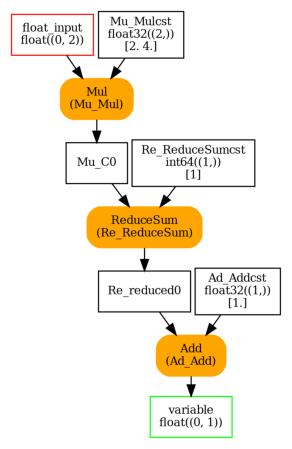

In [12]:
oinf = OnnxInference(onnx_model)
plt.figure(figsize=(10,8))
ax = plot_graphviz(oinf.to_dot())
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Load onnx model from disk and score some data

In [13]:
# retrieve model from disk
sess = rt.InferenceSession('./toy_model.onnx')

In [14]:
# get model names
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

In [15]:
# generate predictions
list_of_predictions = sess.run(
    [label_name], 
    {'float_input': test_df.drop(['y'], axis=1).to_numpy().astype(np.float32)}
)
prediction = list_of_predictions[0]

In [16]:
print(f'prediciton shape: {prediction.shape}\n{prediction}')

prediciton shape: (4, 1)
[[11.]
 [-1.]
 [ 1.]
 [ 7.]]
